In [195]:
#location of the dataset
#DATA_SRC='/home/beangoben/ml_data/mpd.v1/data'
DATA_SRC='../data/raw/5k_subset'
# add src scripts to utilize
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import dist_stats_box
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from IPython.display import display
from tqdm import tqdm_notebook as tqdm

In [197]:
!ls ../data/interim

5k_track_audiofeatures.csv  5k_track_uri.csv
5k_track_genres.csv	    track_uri.csv


In [198]:
t_df = pd.read_csv('../data/interim/5k_track_uri.csv')
print(df.columns)
print(df.shape)

Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence', 'csv_id', 'popularity'],
      dtype='object')
(108870, 20)


In [199]:
df = pd.read_csv('../data/interim/5k_track_audiofeatures.csv')
df['duration_ms']=df['duration_ms'].apply(lambda x: np.clip(x/1000.0,0,600))
print(df.columns)
print(df.shape)
df.head(1)

Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence', 'csv_id', 'popularity'],
      dtype='object')
(108870, 20)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,csv_id,popularity
0,0.0311,https://api.spotify.com/v1/audio-analysis/0UaM...,0.904,226.864,0.813,0UaMYEvWZi0ZqiDOoHU3YI,0.00697,4.0,0.0471,-7.105,0.0,0.121,125.461,4.0,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,audio_features,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0.81,0,67.0


# Preprocess features

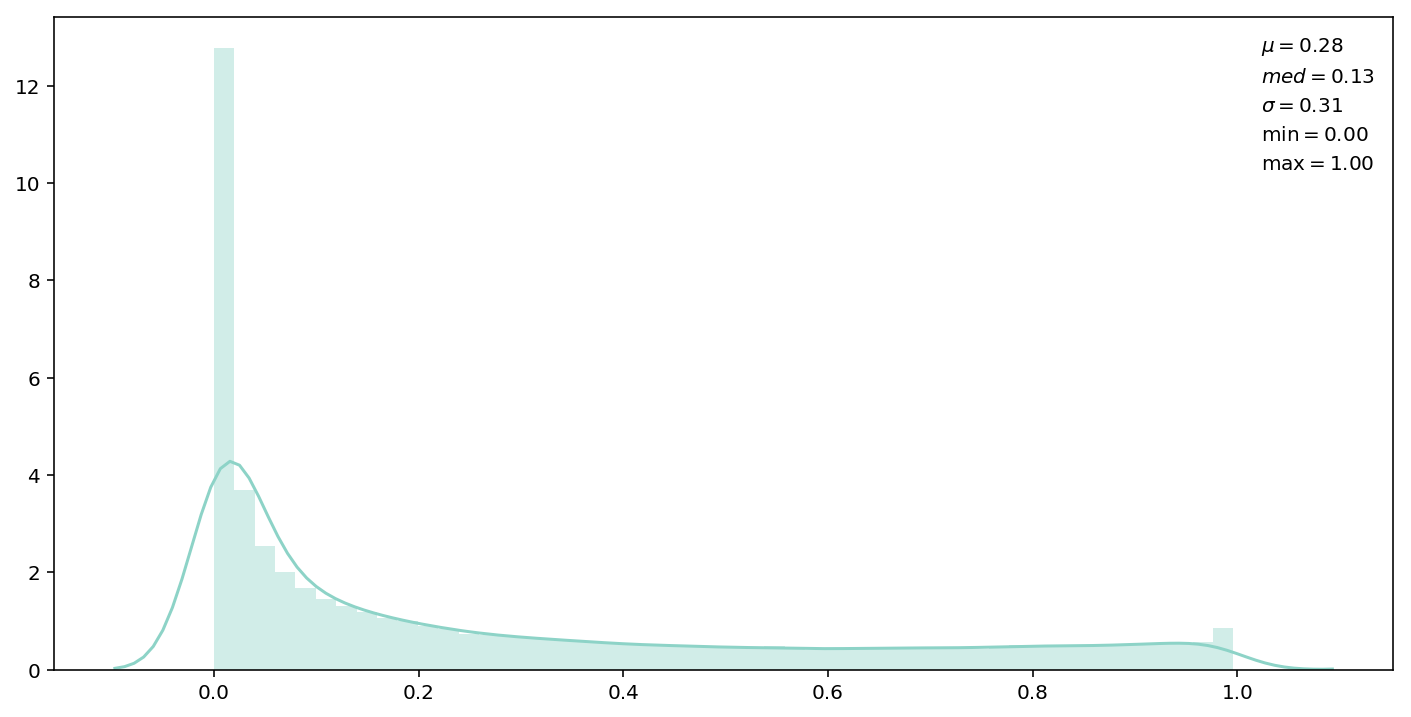

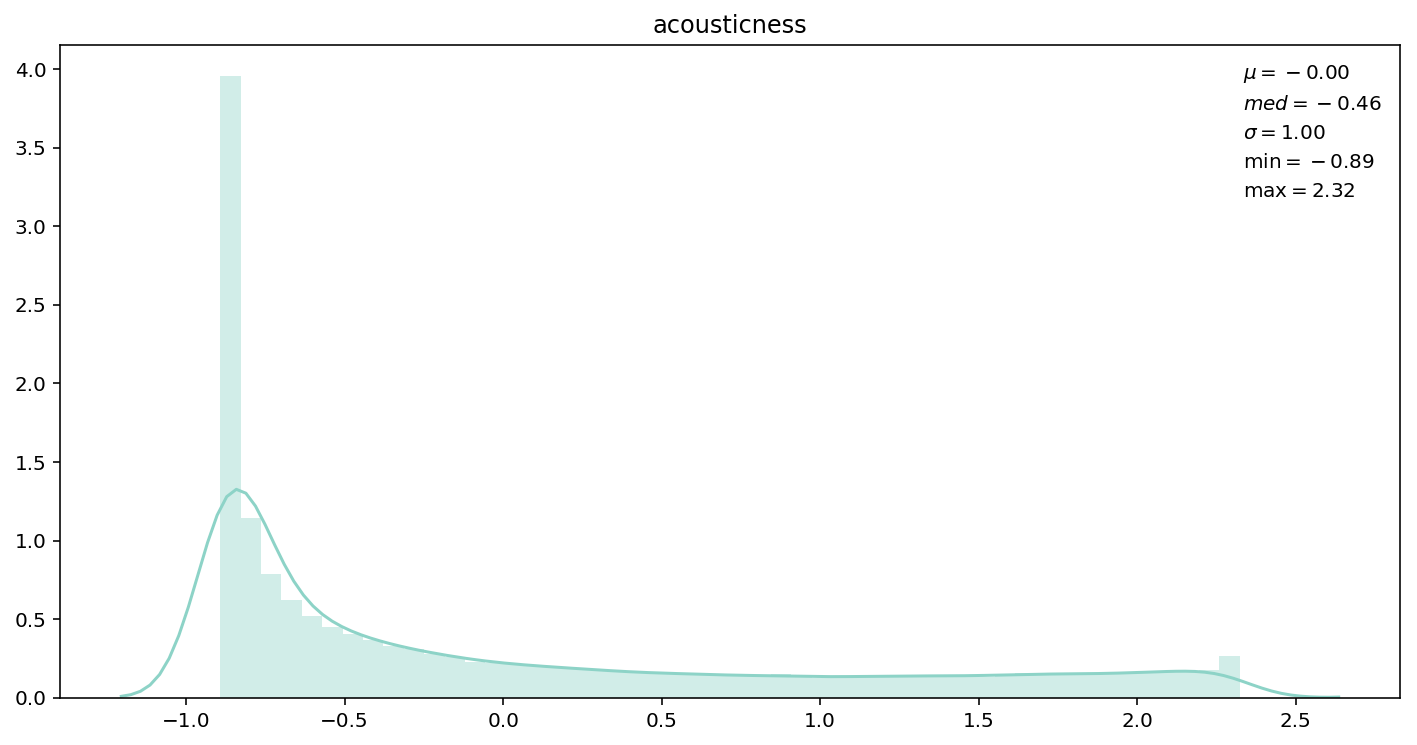

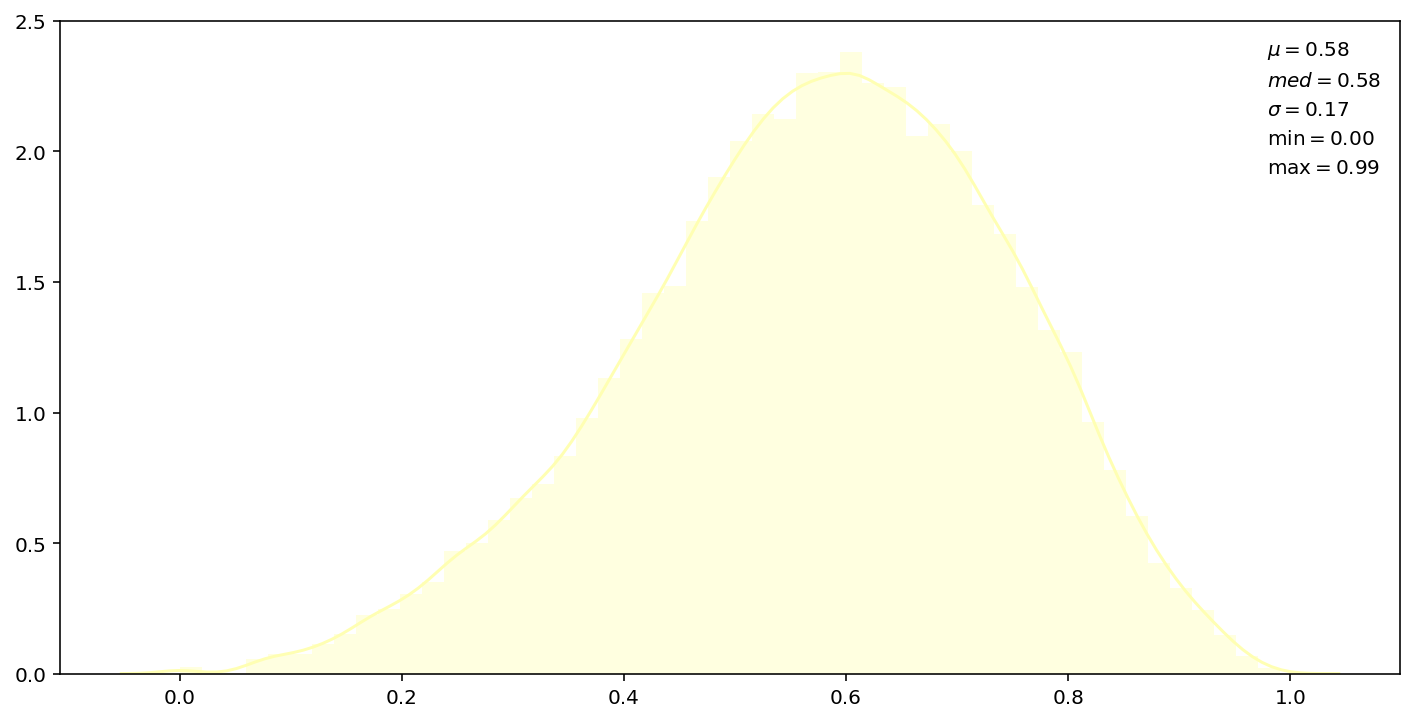

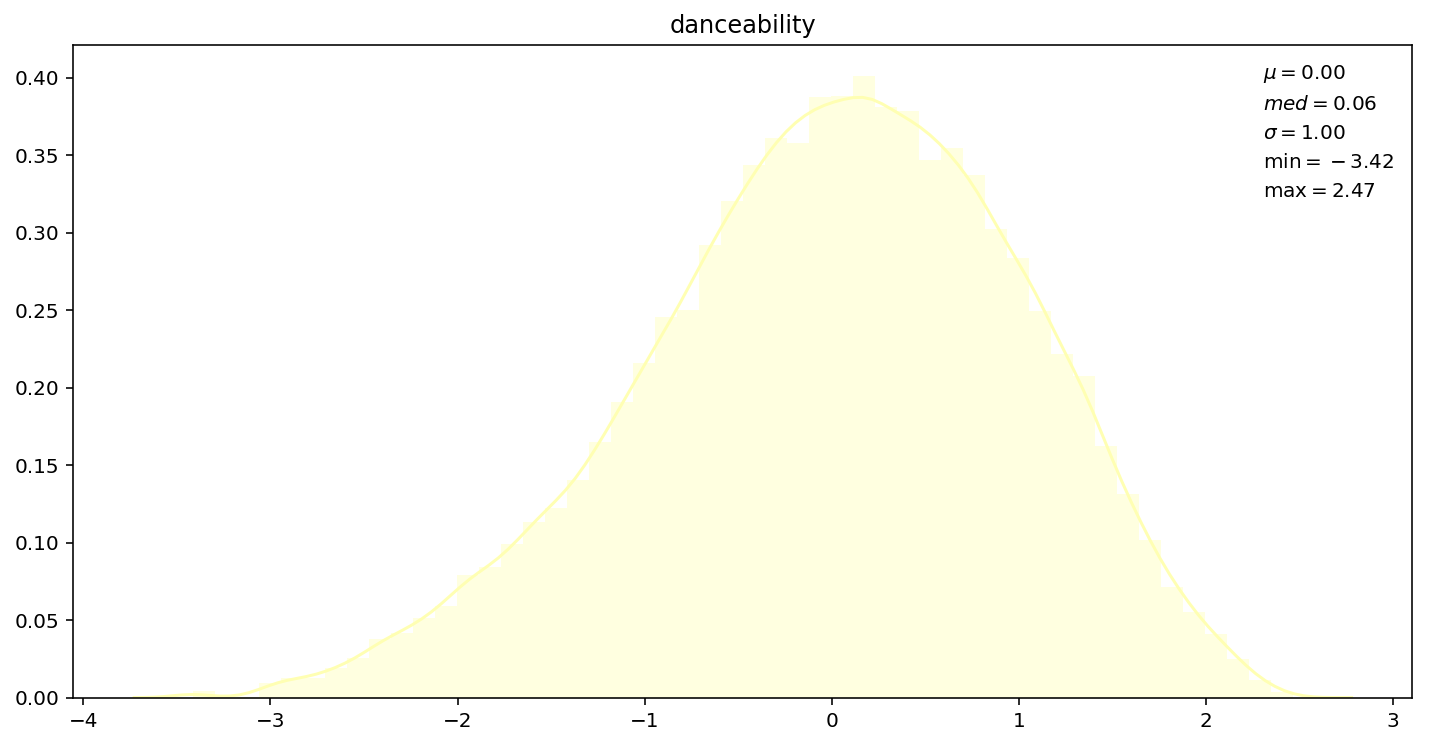

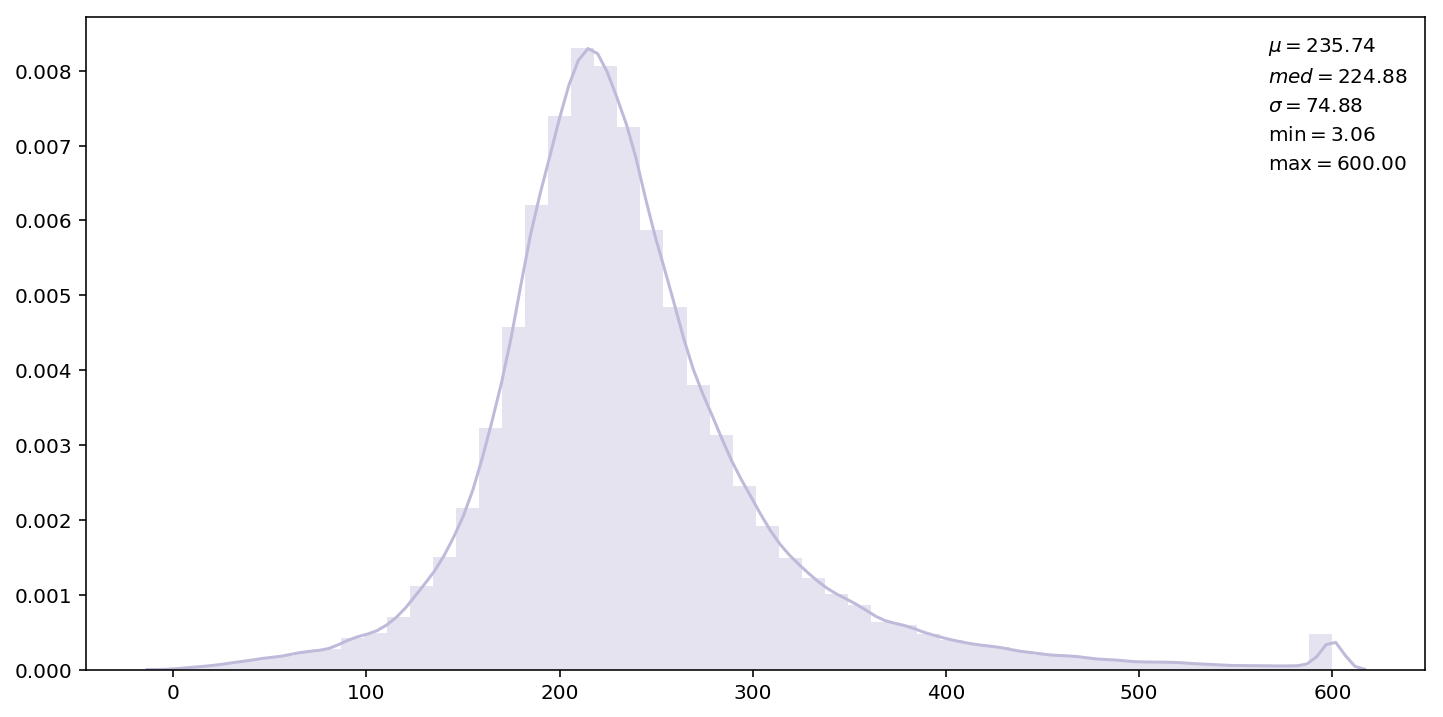

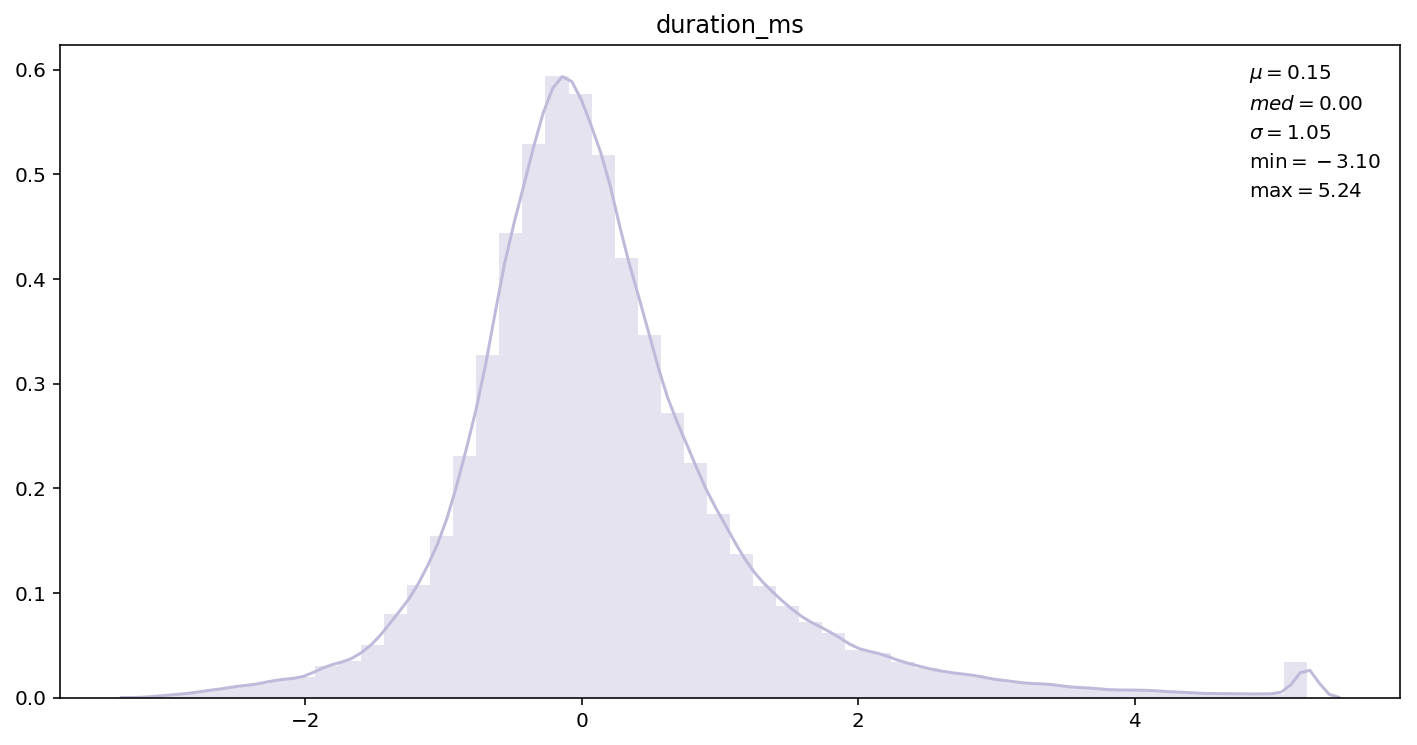

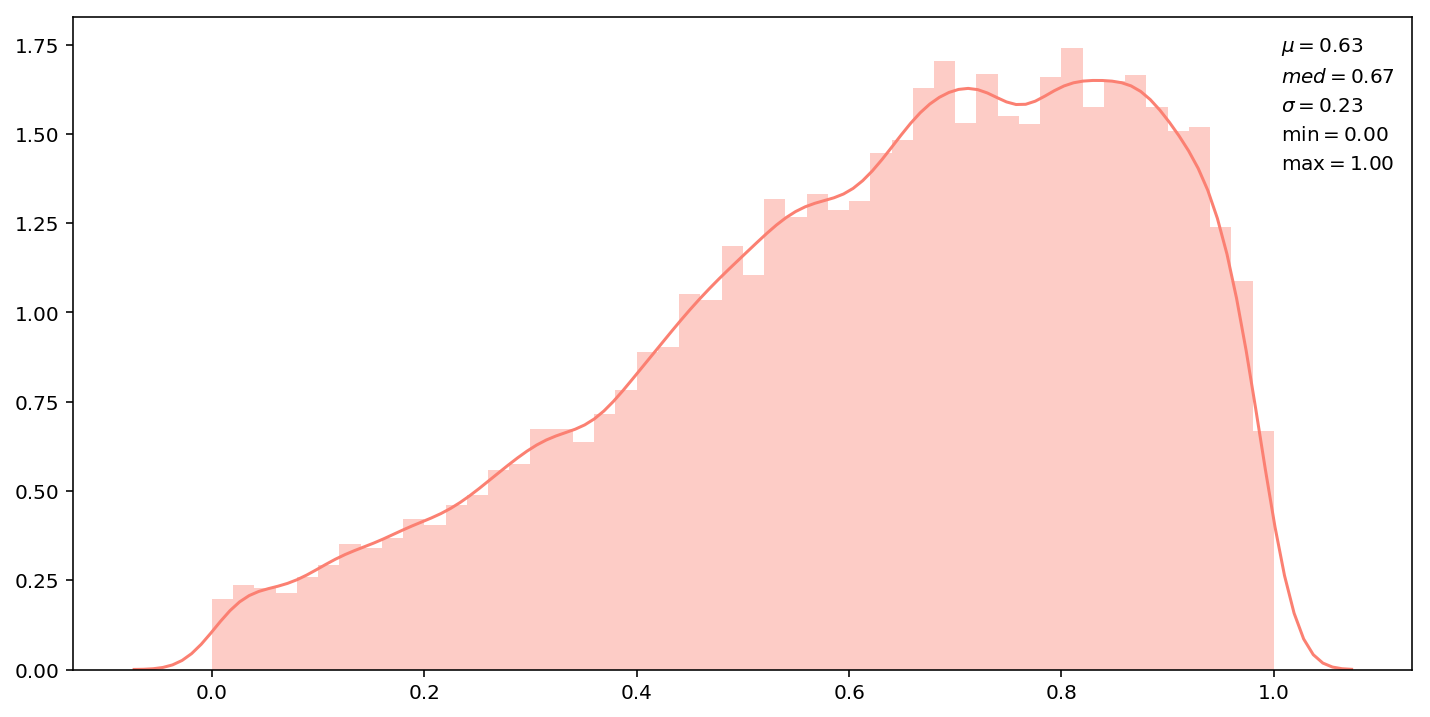

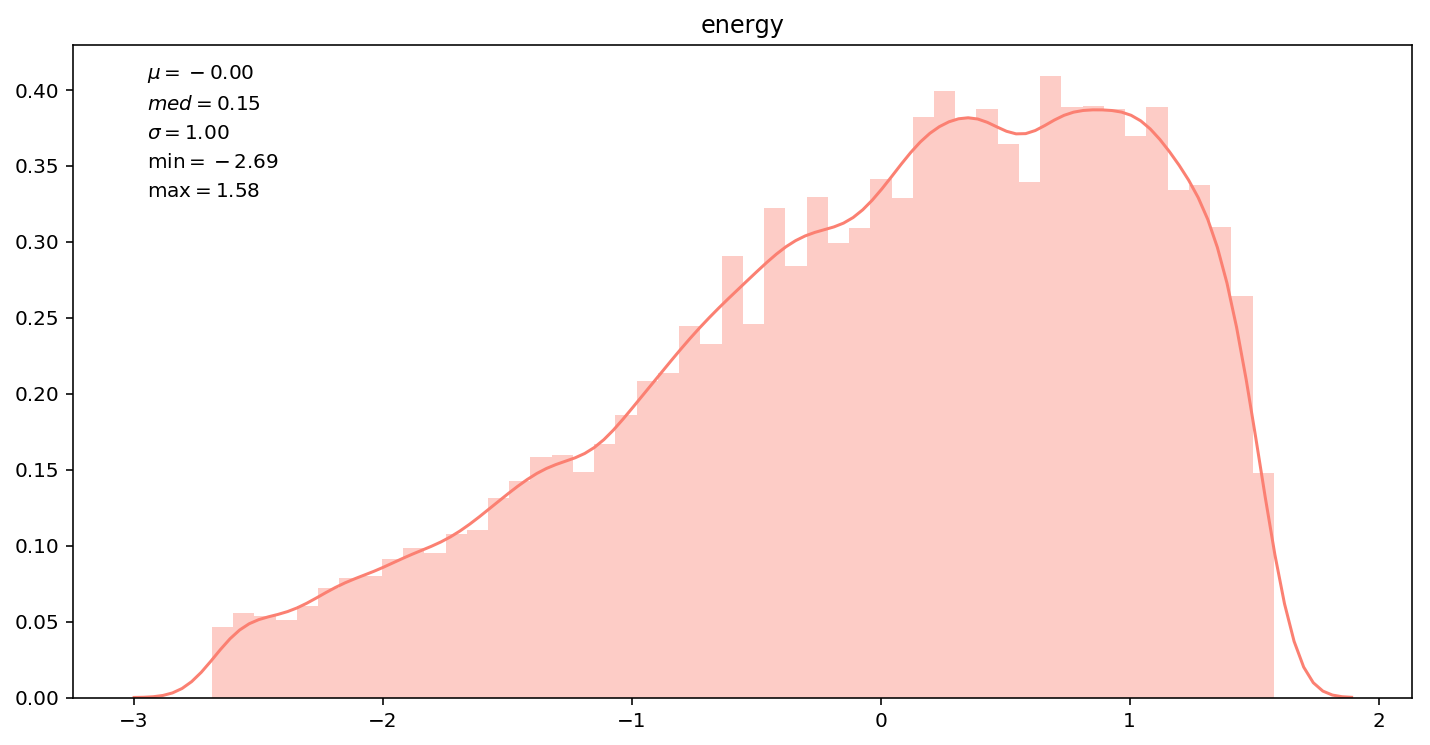

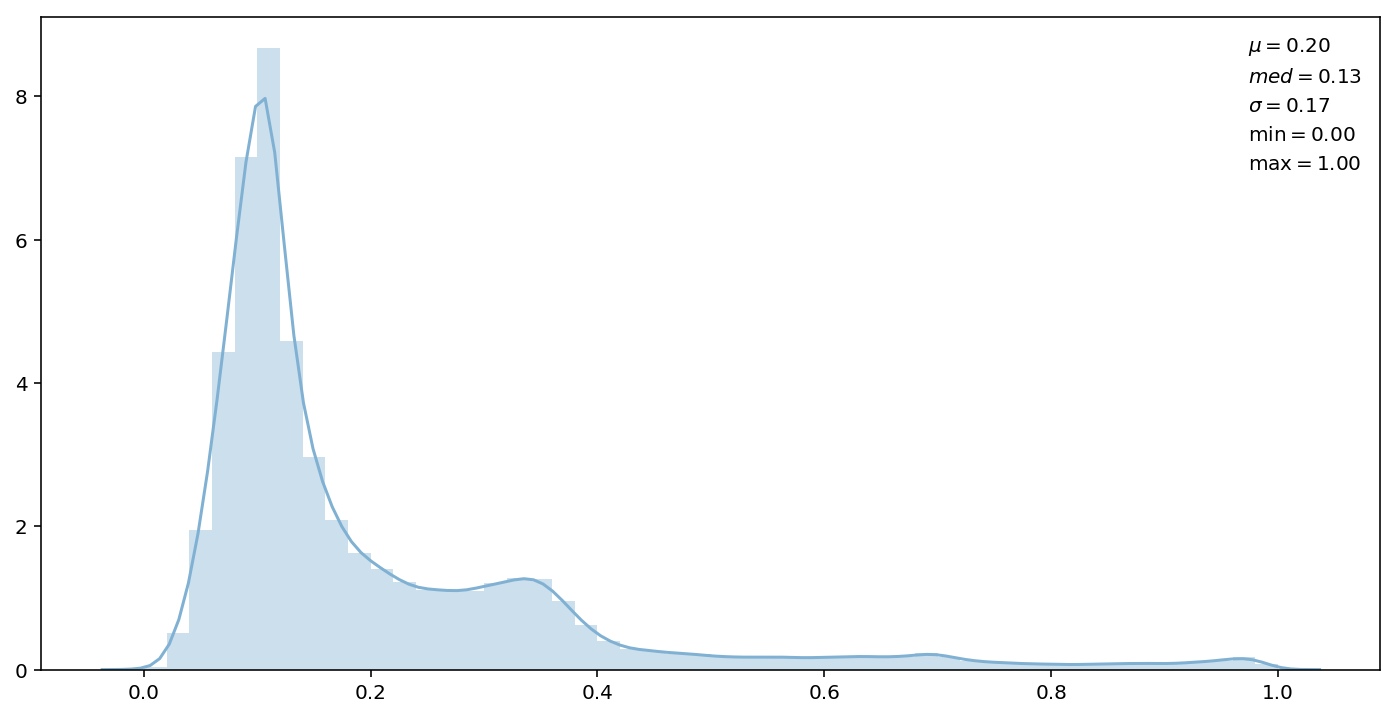

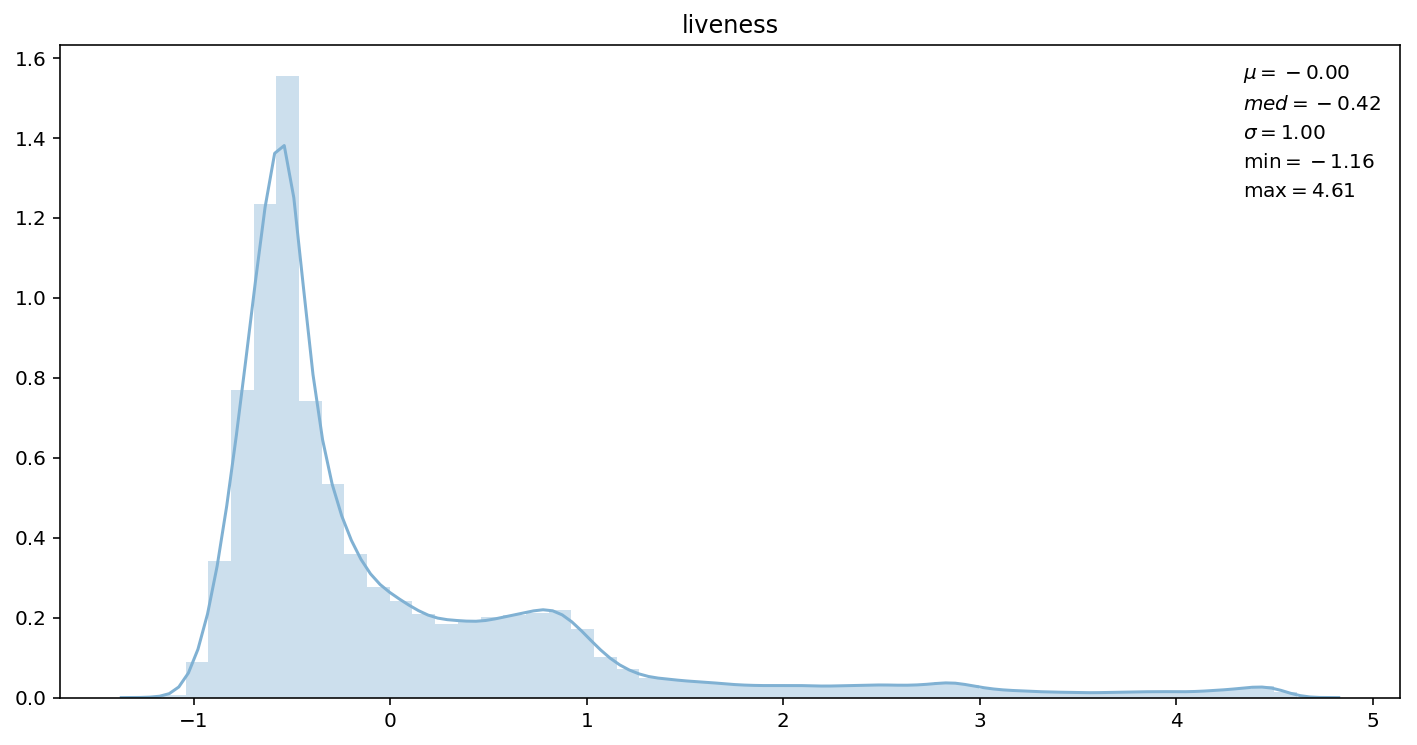

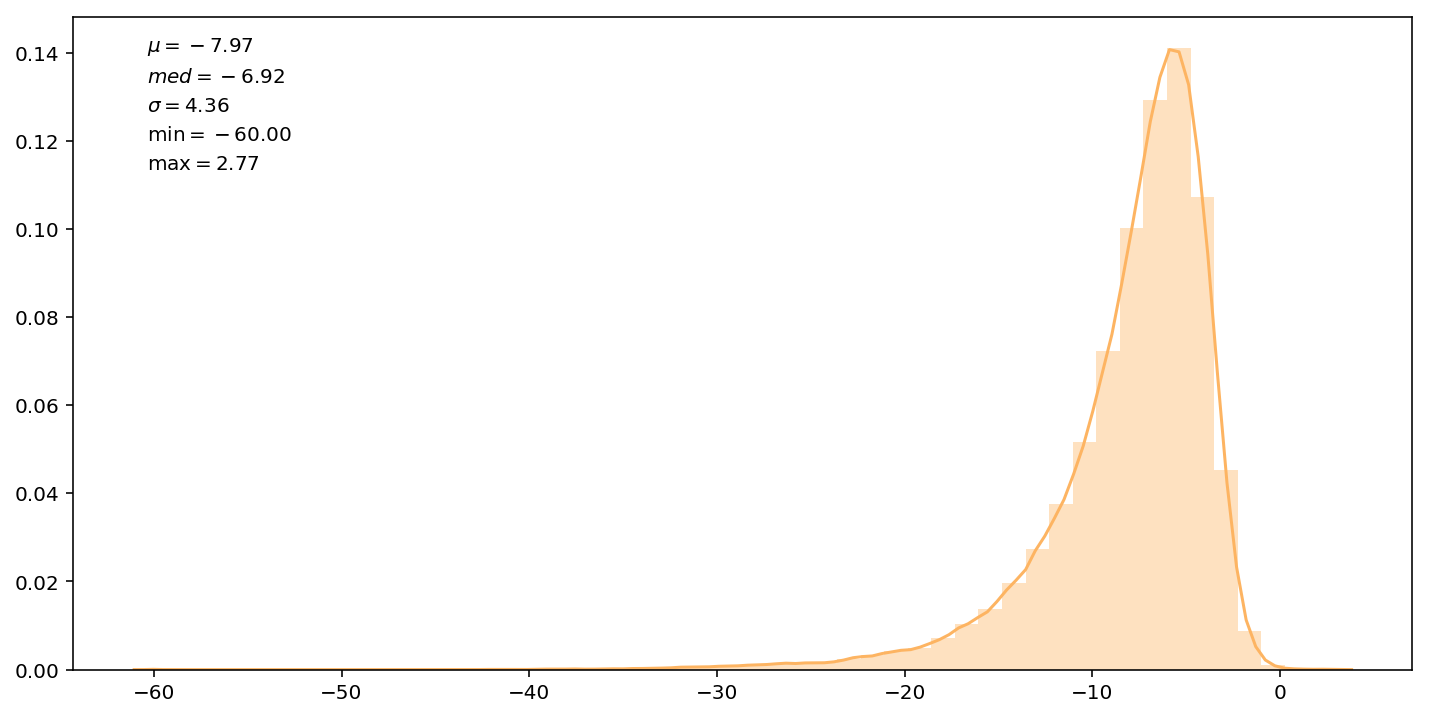

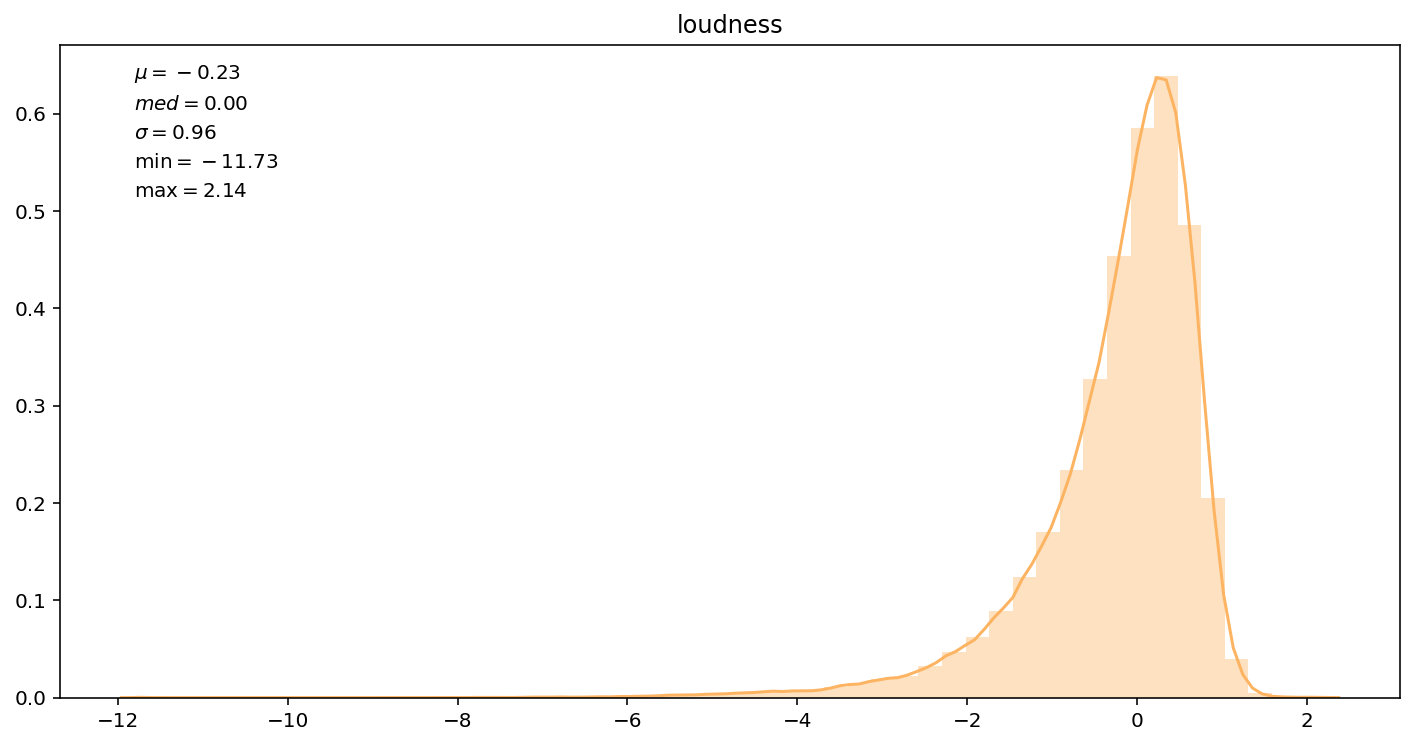

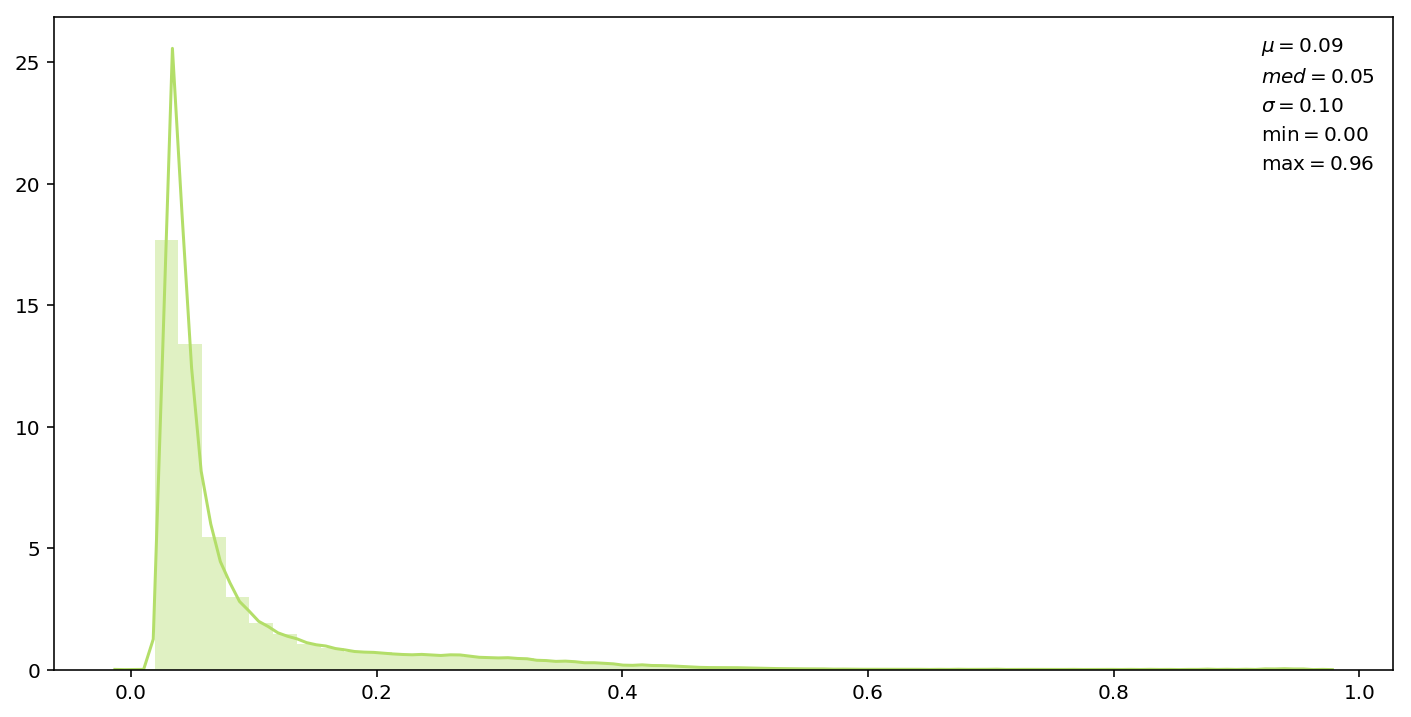

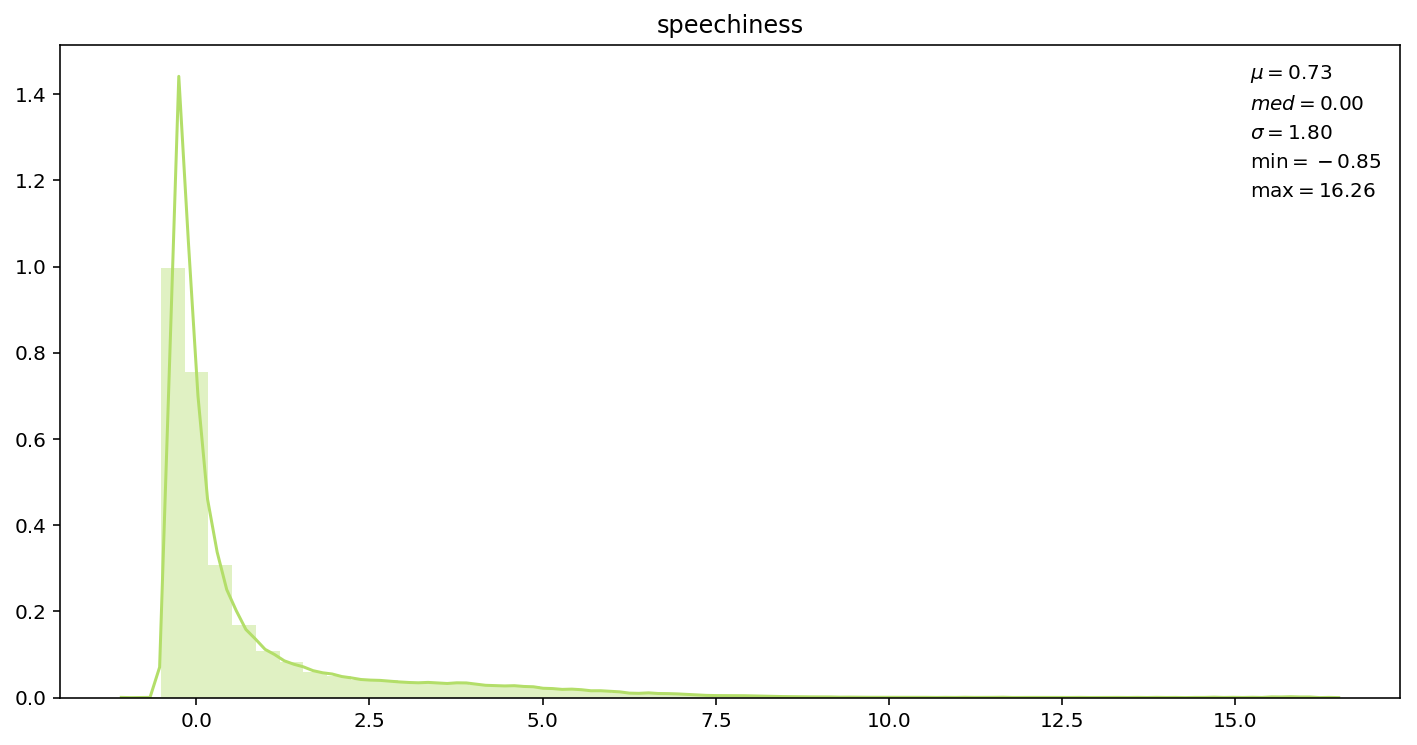

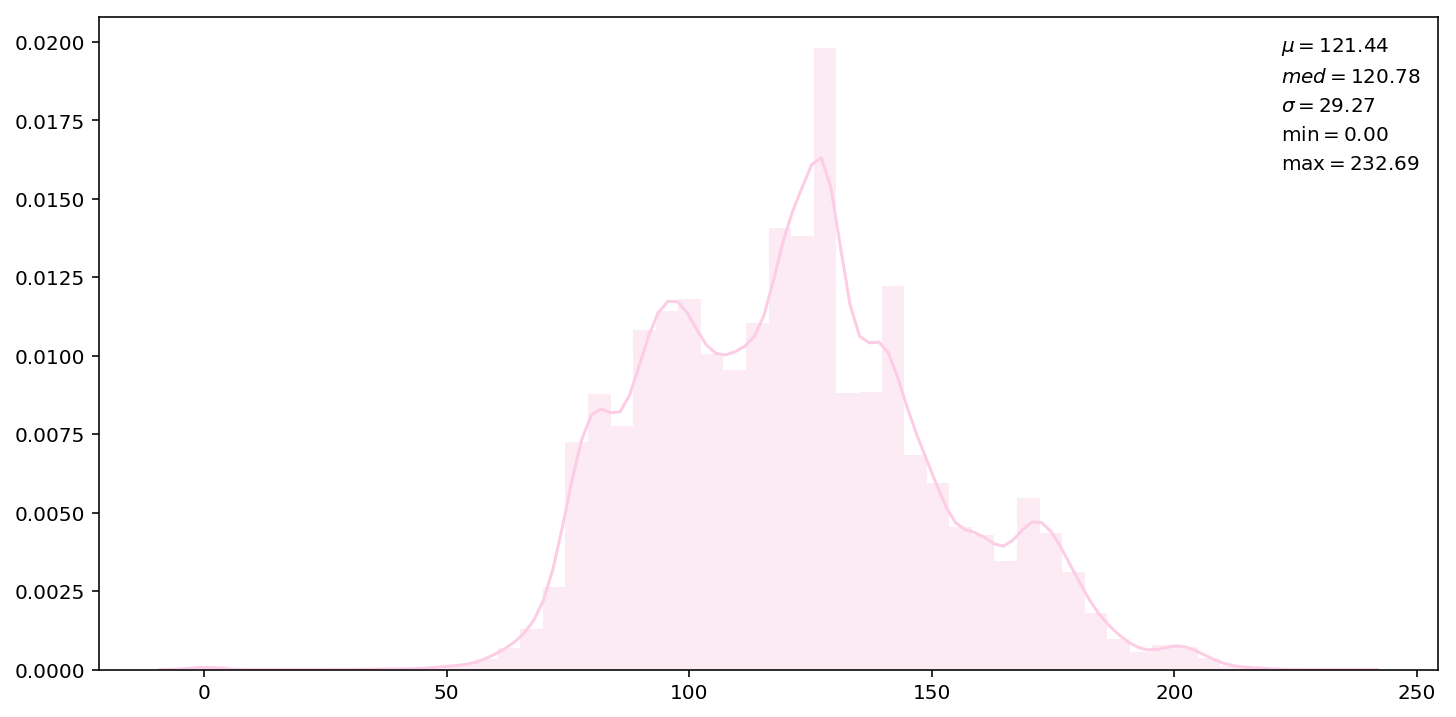

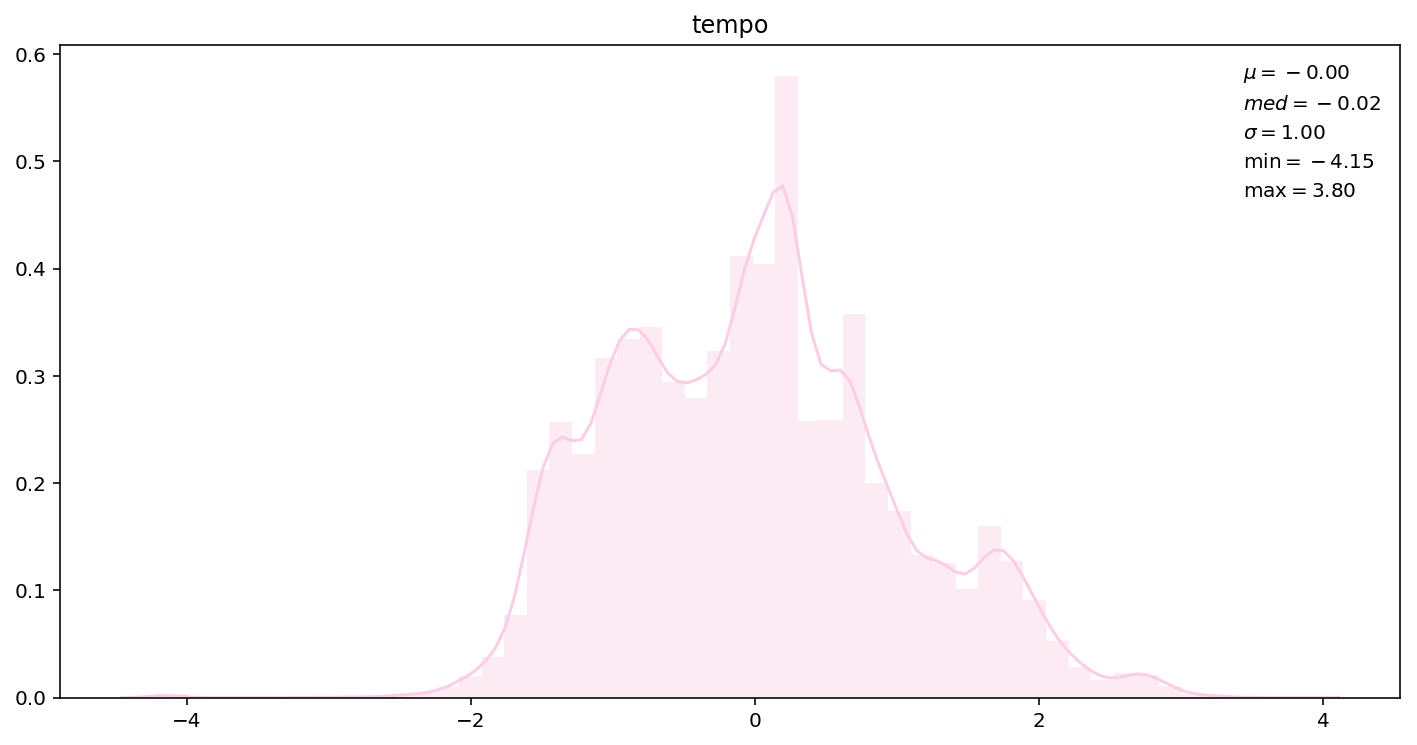

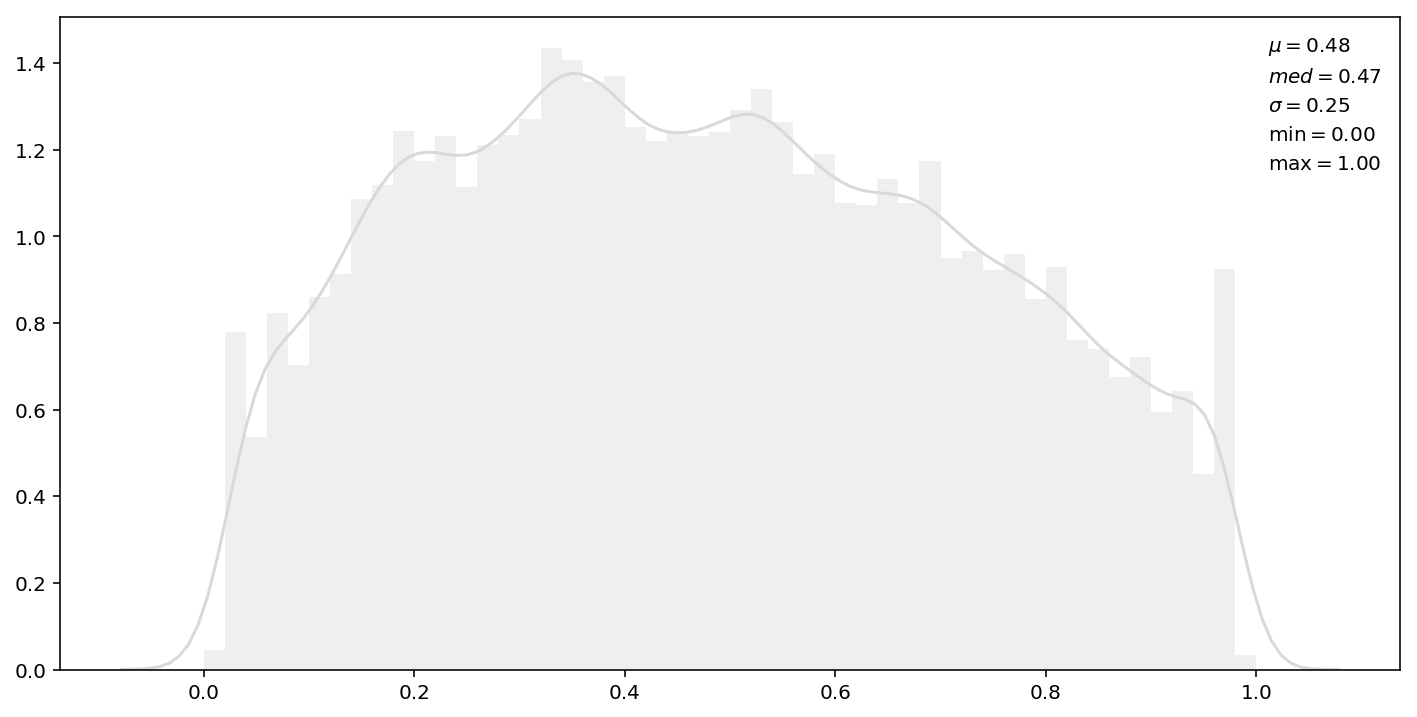

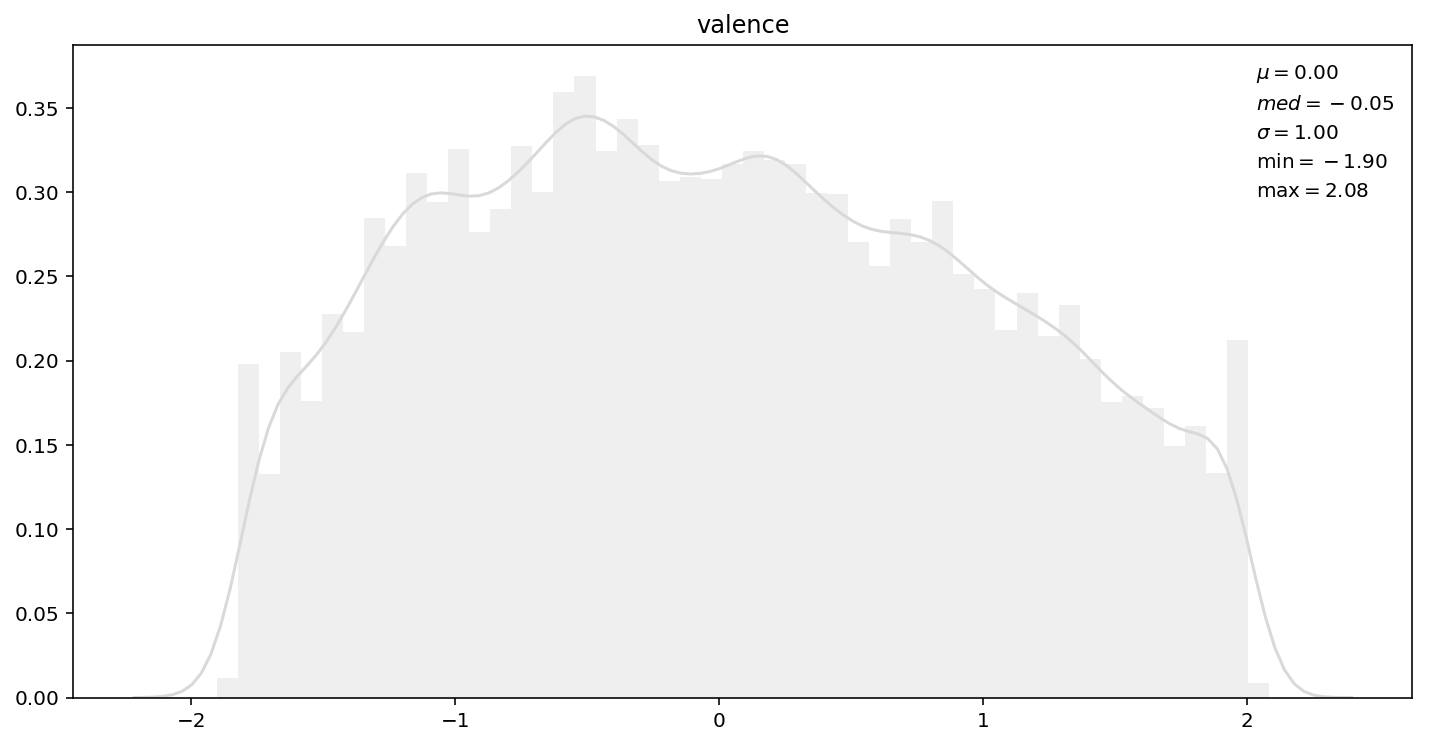

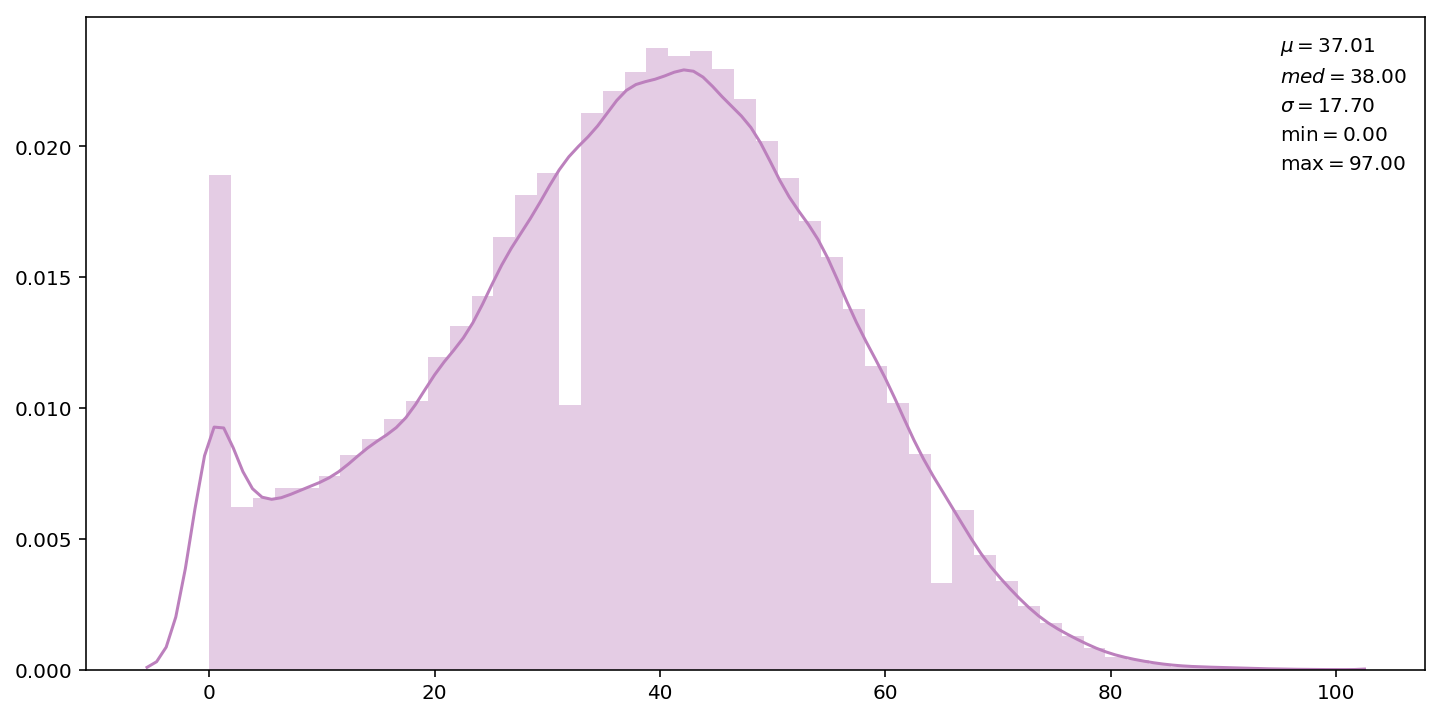

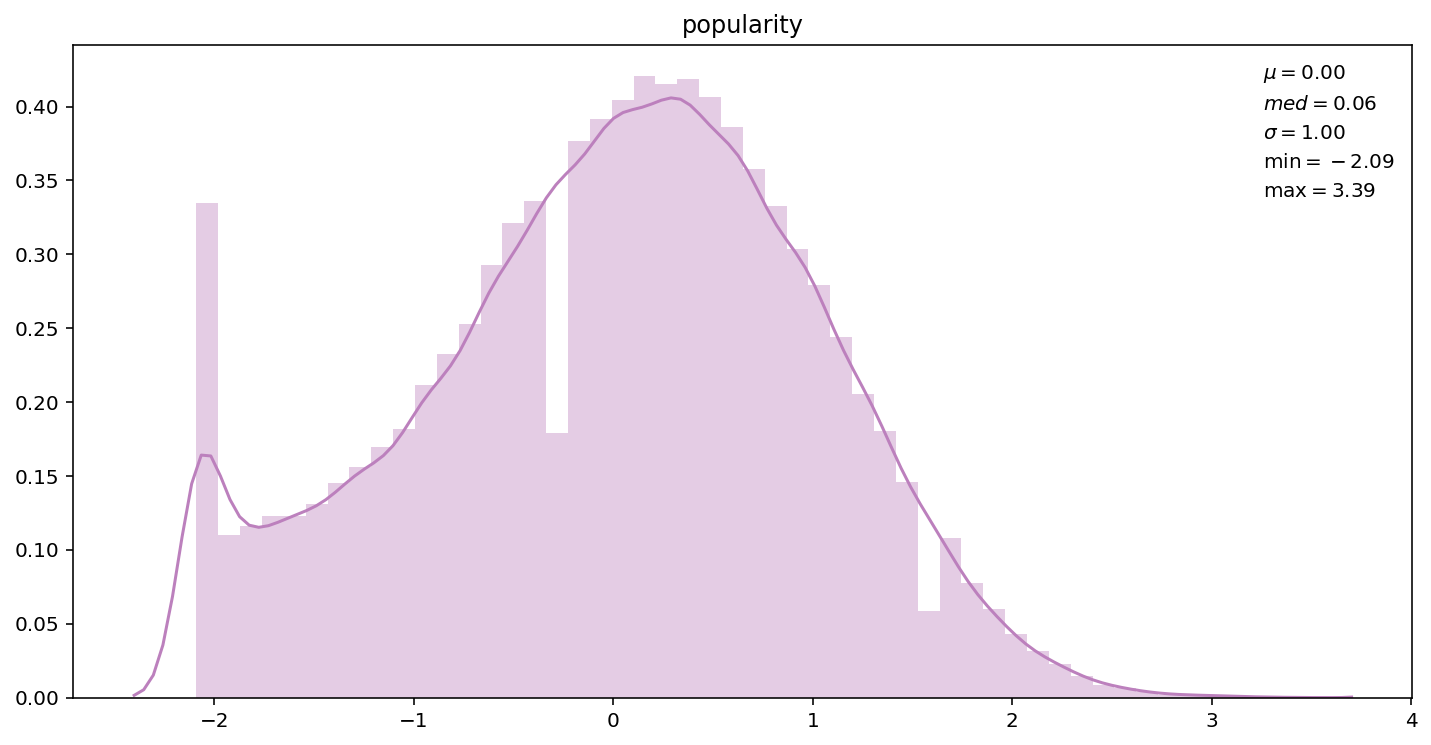

In [201]:
preprocs={'acousticness':StandardScaler(),
          'danceability':StandardScaler(),
          'duration_ms':RobustScaler(),
          'energy':StandardScaler(),
          'liveness':StandardScaler(),
          'loudness':RobustScaler(),
          'speechiness':RobustScaler(),
          'tempo':StandardScaler(),
          'valence':StandardScaler(),
          'popularity':StandardScaler()
}
pal = sns.color_palette('Set3',len(preprocs))
for indx, pair in enumerate(preprocs.items()):
    plt.figure(figsize=(12,6))
    key, pre = pair
    y= df[[key]].dropna().values
    sns.distplot(y,color=pal[indx])
    dist_stats_box(y)
    plt.show()
    plt.figure(figsize=(12,6))
    y_new = pre.fit_transform(y)
    sns.distplot(y_new, color=pal[indx])
    dist_stats_box(y_new)
    plt.title(key)
    plt.show()

# Stack data as a X tensor

In [202]:
preprocs={'acousticness':StandardScaler(),
          'danceability':StandardScaler(),
          'duration_ms':RobustScaler(),
          'energy':StandardScaler(),
          'liveness':StandardScaler(),
          'loudness':RobustScaler(),
          'speechiness':RobustScaler(),
          'tempo':StandardScaler(),
          'valence':StandardScaler(),
          'popularity':StandardScaler()
}
cols=list(preprocs.keys())
f_df = df[cols]
n_missing=sum([ sum(f_df[c].isnull()) for c in cols])
print('{:d} missing values, imputed with mean'.format(n_missing))
# mean inputation
means =  {key:np.mean(f_df[key].dropna().values) for key in cols}
f_df = f_df.fillna(value=means)
# get X vector
X = np.zeros((len(f_df),len(cols)))
for i,pair in enumerate(preprocs.items()):
    key,pre = pair
    X[:,i] = pre.fit_transform(f_df[key].values.reshape(-1, 1)).ravel()
print('X has {}'.format(X.shape))

21 missing values, imputed with mean
X has (108870, 10)


## Load playlist

In [203]:
from data_utils import read_playlist
pid=194
plist = read_playlist('../data/raw/5k_subset',pid)
n_songs = len(plist['tracks'])
print(n_songs)
xp = np.zeros((n_songs,len(cols)))
xp_ids = np.zeros(n_songs,int)
for track in plist['tracks']:
    row = t_df[t_df['uri']==track['track_uri']].iloc[0]
    indx = row['csv_id']
    xp_ids[track['pos']]=int(indx)
    xp[track['pos'],:]=X[indx,:]

130


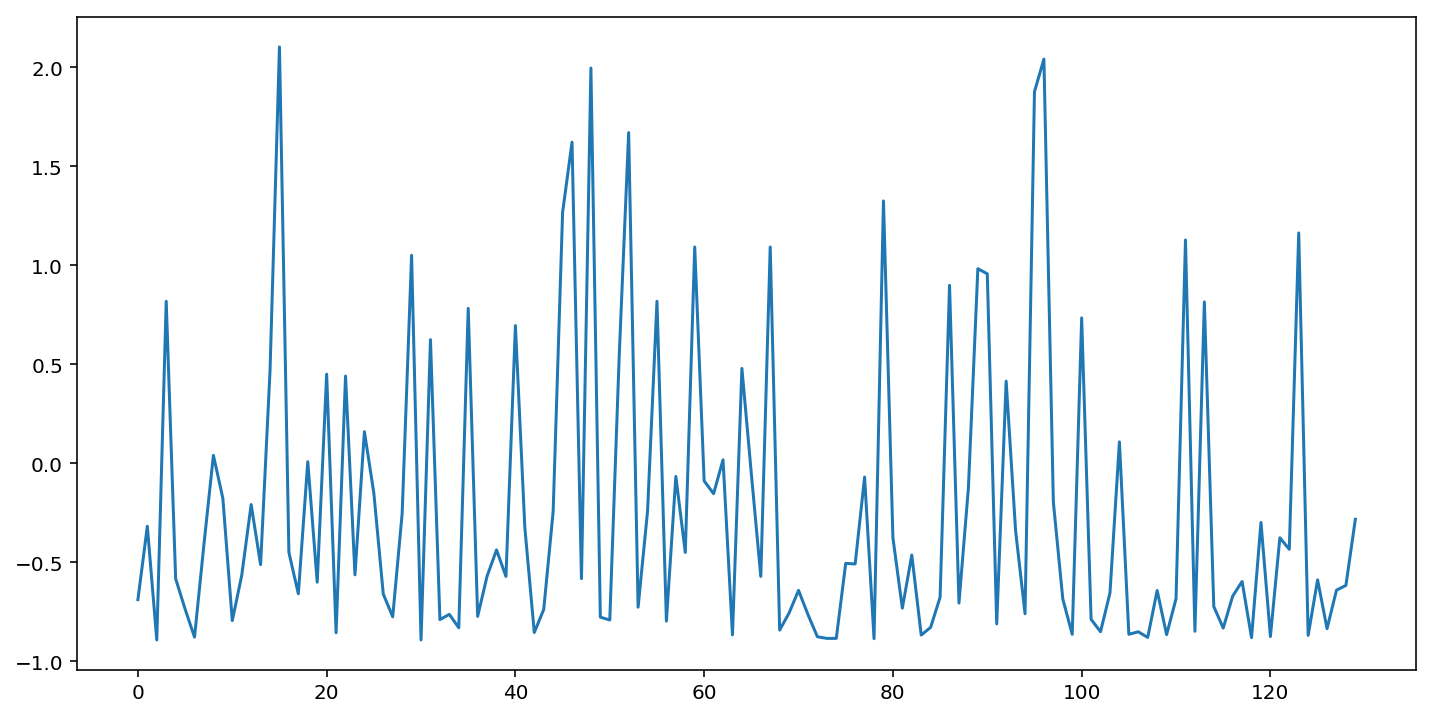

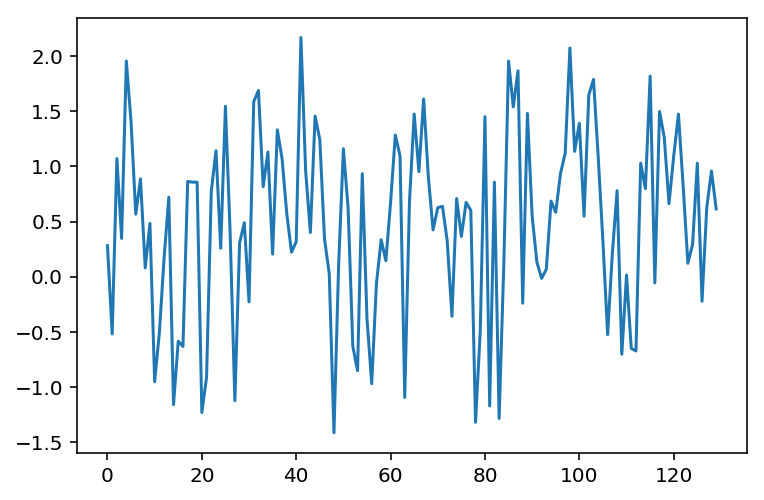

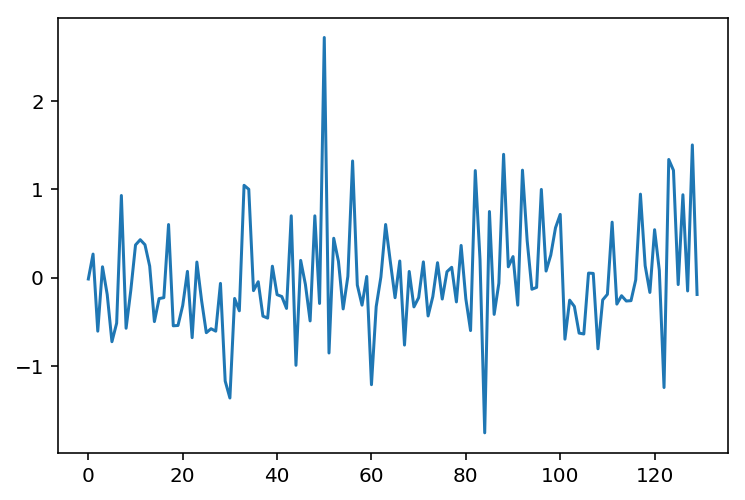

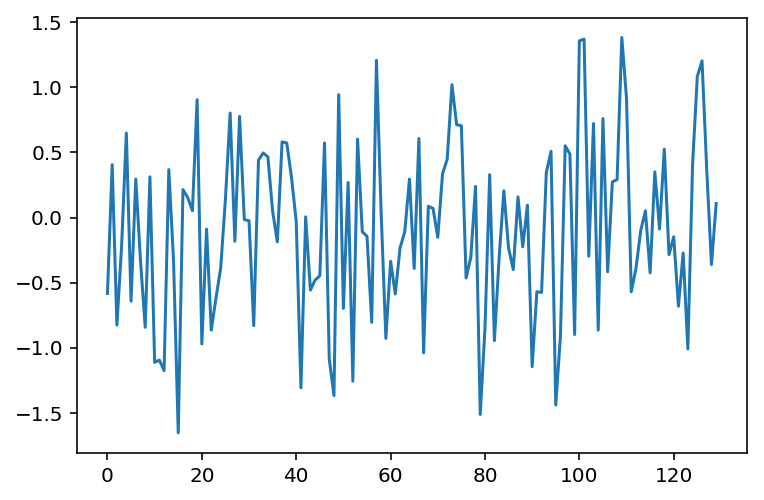

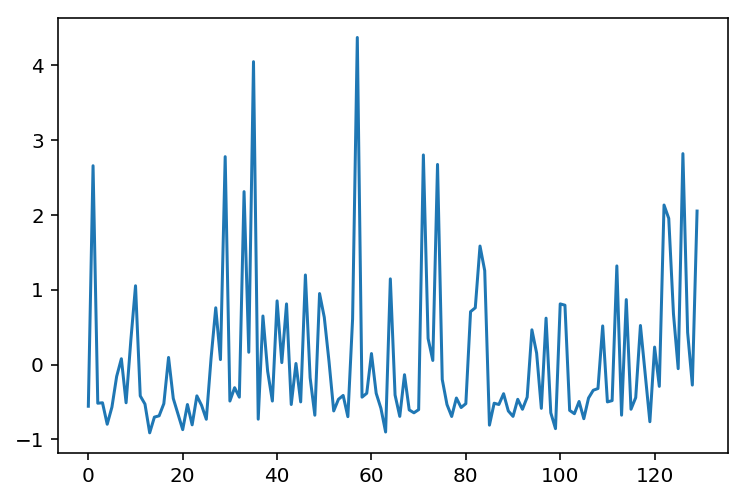

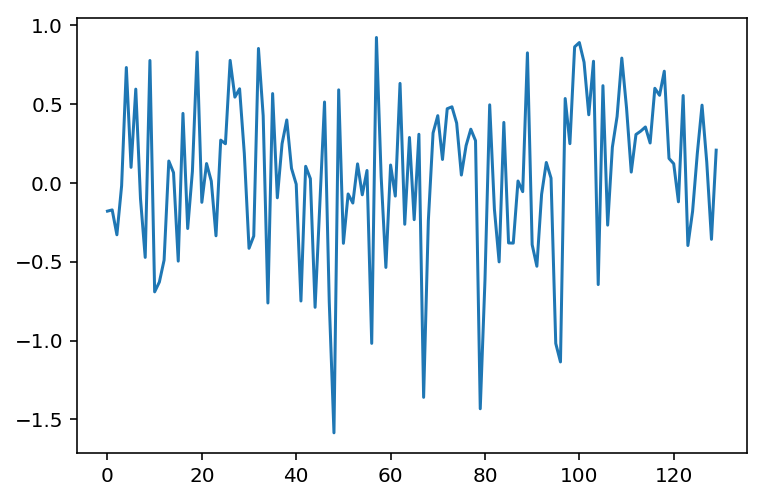

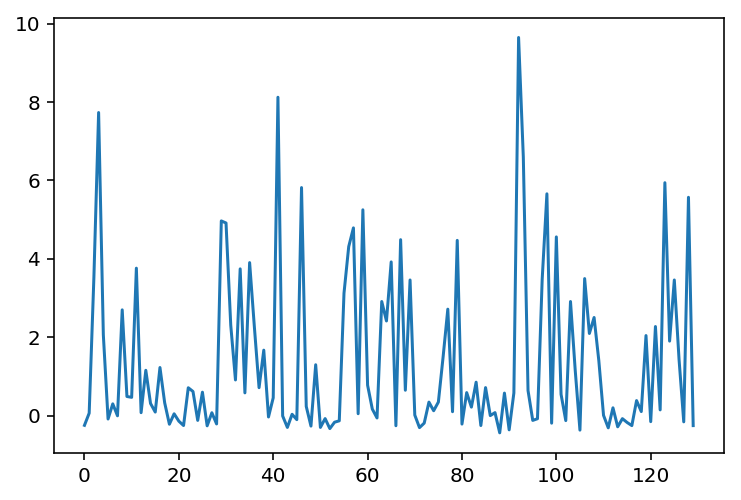

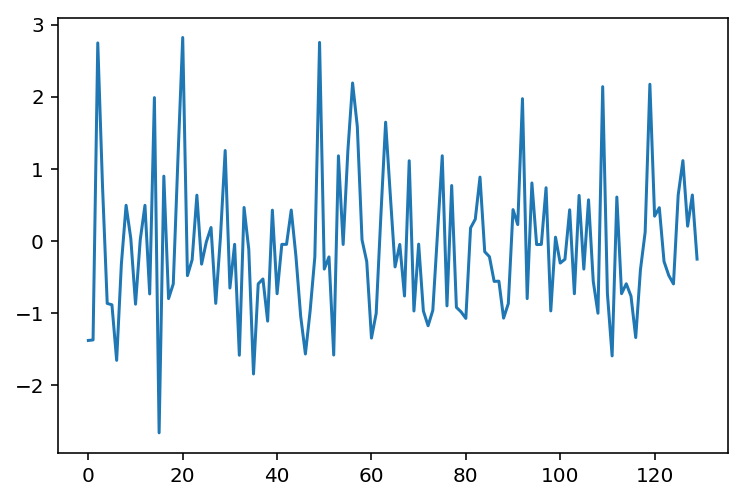

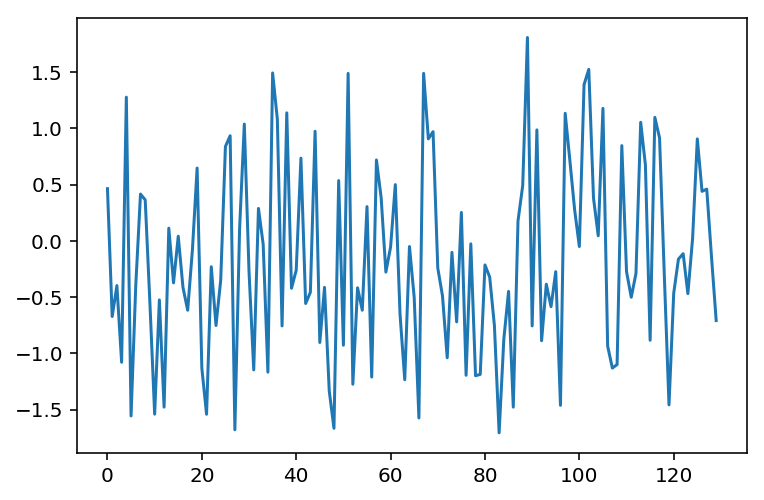

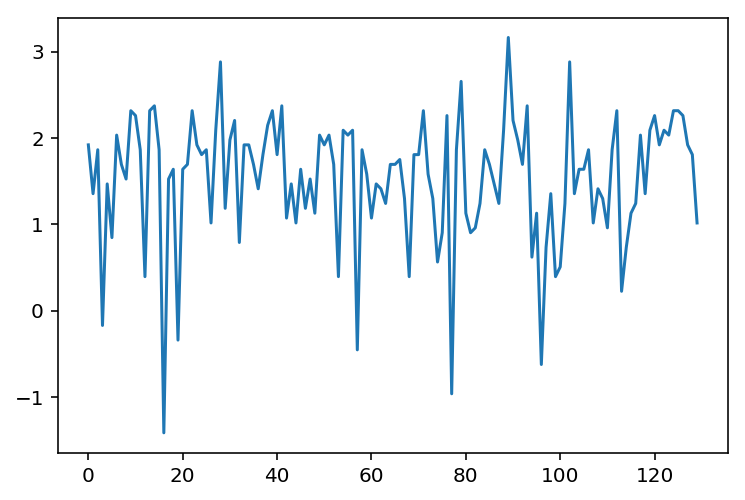

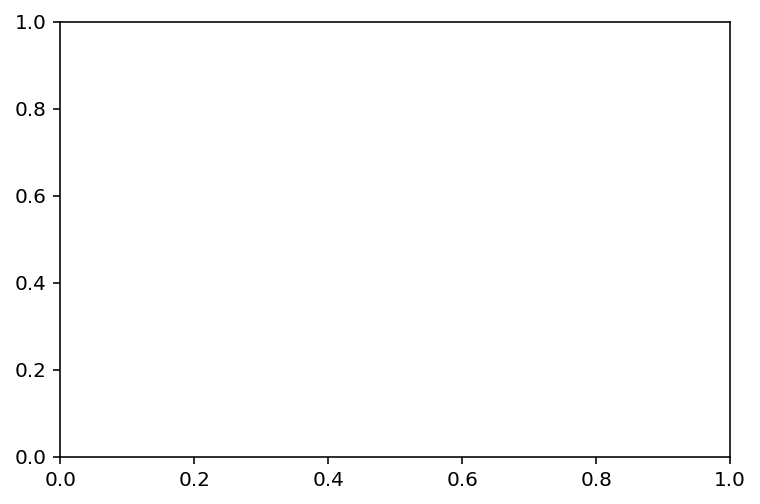

In [267]:
plt.figure(figsize=(12,6))
for indx,key in enumerate(preprocs.keys()):
    plt.plot(xp[:,indx],label=key)
    plt.show()
plt.legend()
plt.show()

In [219]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim_closest(X,x_query,n=1):
    lim = n+1
    sim = cosine_similarity(X,x_query.reshape(1,-1)).ravel()
    print(sum(sim>0.95))
    plt.show()
    ind = np.argpartition(sim, -lim)[-lim:]
    ind = ind[np.argsort(sim[ind])]
    
    return ind[:-1],sim[ind[:-1]]


def cosine_sim_top(X,x_query,tol=0.95):
    sim = cosine_similarity(X,x_query.reshape(1,-1)).ravel()
    lim = sum(sim>tol)
    ind = np.argpartition(sim, -lim)[-lim:]
    ind = ind[np.argsort(sim[ind])]
    
    return ind[:-1],sim[ind[:-1]]


In [206]:
from IPython.core.display import display, HTML
def html_header(txt,lvl=1):
    return display(HTML('<h{:d}>{:s}</h{:d}>'.format(lvl,txt,lvl)))

In [268]:
from metrics import r_precision
suggest_df=pd.DataFrame()
n_top=10
x_pred = np.zeros(n_songs*n_top,int)
x_pred =[]
for i in tqdm(range(n_songs),total=n_songs):
    x_partial = xp[:i,:]
    x_query = xp[i-1,:]
    ind,sim = cosine_sim_top(X,x_query,0.9)
    #x_pred[i*n_top:(i+1)*n_top]=ind
    x_pred.append(ind)
    top_suggested_track = t_df.iloc[ind[0]]
    suggest_df = suggest_df.append(top_suggested_track)
    x_next = xp[i,:]

score = r_precision(xp_ids,list(np.concatenate(x_pred)))
html_header('Score = {}'.format(score))
html_header('Suggested')
display(suggest_df[['artist','title']])
html_header('Real')
display(t_df.iloc[xp_ids][['artist','title']])

HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

,artist,title
92788,charli xcx,dreamer
17417,moby,flower
44784,kendrick lamar,no make-up her vice
55168,sob x rbe,slide
16641,the chainsmokers,paris - jewelz & sparks remix
16228,omarion,i'm up feat kid ink & french montana
21221,olivia o'brien,empty
53933,matoma,find love feat dboy
6870,fleetwood mac,dreams - 2004 remastered edition
60579,g herbo,kill shit feat lil bibby [bonus track]


,artist,title
9385,max,lights down low
9386,the neighbourhood,greetings from califournia
2704,drake,the motto
8292,ariana grande,best mistake
4081,travis porter,ayy ladies
1950,nelly,the fix feat jeremih
1219,hoodie allen,surprise party feat blackbear
9387,jacquees,come thru
9388,blackbear,suckerz
9031,snakehips,don't leave
